# Data Preparation

In this sectiono we load in and prepare the data for our machine learning.

In [3]:
# !pip install scipy
# !pip install pandas
# !pip install scikit-learn

In [4]:
# !conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# # Anything above 2.10 is not supported on the GPU on Windows Native
# !pip install "tensorflow<2.11"


In [5]:
# !pip list
# !pip install -q seaborn

In [32]:
import os
import scipy.io as sio
import pandas as pd
from scipy.io import loadmat
import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
np.set_printoptions(precision=3, suppress=True)

## Ingesting the data

The following data is from a Nasa dataset with n refferring to the iteration number of the dataset used. 

    Voltage_measured: Fuel Cell terminal voltage (Volts)
    Current_measured: Fuel Cell output current (Amps)
    Temperature_measured: Fuel Cell temperature (degree C)
    Current_load: Current measured at load (Amps)
    Voltage_load: Voltage measured at load (Volts)
    Time: Time vector for the cycle (seconds)
    Capacity: Fuel Cell capacity (Ahr) for discharge till 2.7V
    Datetime: the date and time of the start of the cycle
    Ambient_temperature: Temperature in which the fuel cell is stored (degree C)
    Cycle: Charge cycle of the fuel cell


In [7]:
n = 'B0005'
df = pd.read_csv('data_frames/' + 'NASA_cycle_dataset_' + n +'.csv',
                 parse_dates = ["datetime"]).drop(["Unnamed: 0"], axis = 1)
df.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,NaN
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,NaN
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,NaN
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,NaN
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,NaN


## Beginning Data engineering

In the Below cells we are attempting to fill in the missing values. A brief look at the dataset showed that each cycle potentially had a capacity for at least one of its rows. 

First we test that theory:

In [8]:
capacity_counts = pd.DataFrame(df.groupby('cycle')['capacity'].nunique())
zero_capacity_rows = capacity_counts[capacity_counts['capacity'] != 1]
# capacity_counts
zero_capacity_rows

,capacity
cycle,
169,0
170,0


In [9]:
cap_std = df['capacity'].std()
cap_mean = df['capacity'].mean()

print(f"The standard deviation of capacity is {round(cap_std, 4)}.")
print(f"The average of capacity is {round(cap_mean, 4)}.")
print(f"This makes the standard deviation {round(cap_std/cap_mean*100,2)}% of the mean")

The standard deviation of capacity is 0.1824.
The average of capacity is 1.5603.
This makes the standard deviation 11.69% of the mean


The above cell shows that there is a singular battery capacity for each cycle except for 169 and 170.
For now we shall remove those two cycles as there is a large amount of deviation.

In [10]:
df = df[df['cycle'] <  169]
caps = pd.DataFrame(df.groupby('cycle')['capacity'].max())
temp = df.merge(caps, on='cycle', how='left').ffill()
temp = temp.drop(["capacity_x"], axis = 1).rename(columns = {"capacity_y" : "capacity"})
df = temp
temp.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,1.856487
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,1.856487
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,1.856487
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,1.856487
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,1.856487


In [11]:
print(f"The number of unique vlaues for ambient_temperature is: {df['ambient_temperature'].nunique()} ")

print(f"The Maximum value for voltage_measured is: {df['voltage_measured'].max()} ")

The number of unique vlaues for ambient_temperature is: 1 
The Maximum value for voltage_measured is: 8.393141180564633 


This shows that there is a consistency of ambient temperature in this dataset. This will be a limitation in the final model. We also need to check whether this voltage (which seems high)  is an outlier or not

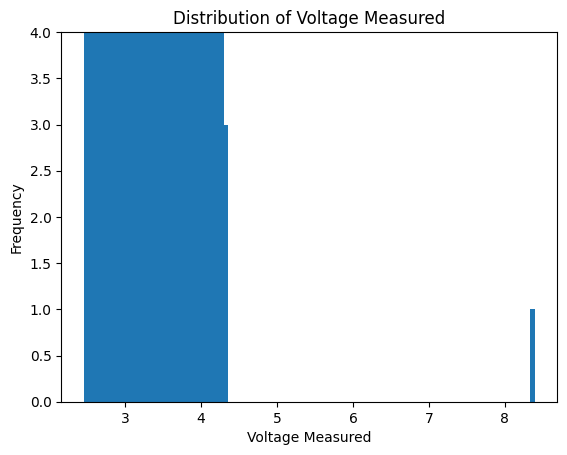

In [12]:
plt.hist(df['voltage_measured'], bins = 100)
plt.xlabel('Voltage Measured')
plt.ylabel('Frequency')
plt.title('Distribution of Voltage Measured')
plt.ylim(0,4)
plt.show()

As shown above, there is only a singular value above 4.xxxx, making the maximum vlaue shown above a clear outlier. We need to remove this value and so shall remove it.

In [13]:
value = df['voltage_measured'].max()
df = df[df['voltage_measured'] != value]

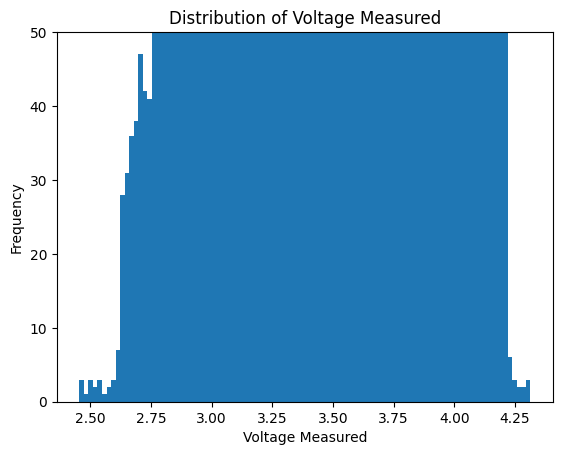

In [14]:
plt.hist(df['voltage_measured'], bins = 100)
plt.xlabel('Voltage Measured')
plt.ylabel('Frequency')
plt.title('Distribution of Voltage Measured')
plt.ylim(0,50)
plt.show()

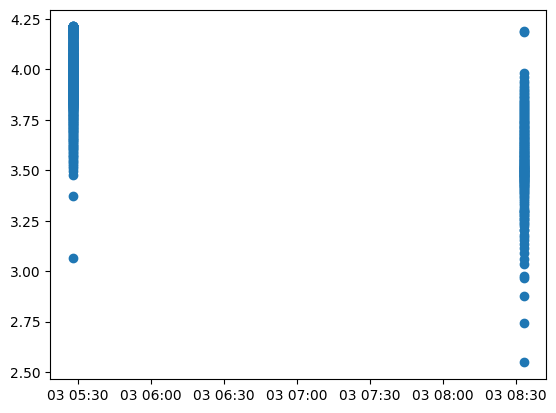

In [15]:
cycle = 5
plt.scatter(df[df['cycle'] == cycle]['datetime'], df[df['cycle'] == cycle]['voltage_measured'])

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df['SOC'] = ((df['voltage_measured'] - 2.7)/(df['voltage_measured'].max() - 2.7))

df.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity,SOC
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,1.856487,0.726910
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,1.856487,0.933546
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,1.856487,0.933602
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,1.856487,0.932955
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,1.856487,0.932824


# Machine Learning (RNN)

Now we begin to build our Recurrent Neural Network

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
import warnings

In [18]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [19]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
prep_df = df.drop(['datetime', 'ambient_temperature'], axis = 1)

In [34]:
X = df[["cycle", "voltage_measured", "current_measured", "temperature_measured", "current", "voltage", "time"]]
y = df["SOC"]

## Normalisation

Here we will normalise the values to give equal weight to each feature

In [35]:
# Normalize the input features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [36]:
# Reshape data for the RNN
X = X.reshape(X.shape[0], 1, X.shape[1])

### Splitting the Dataset for training

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Regression with CNN

In [38]:
def create_RNN():
    model = keras.Sequential()
    model.add(keras.layers.SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(keras.layers.Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def plot_loss(history, title):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [SOC]')
    plt.title(title)
    plt.legend()
    plt.grid(True)

In [39]:
rnn_model = create_RNN()

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4608      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


In [40]:
epochs = 40
checkpoint_filepath = 'checkpoints\RNN_SOC{epoch:02d}-{val_loss:.4f}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='mean_squared_error',
    mode='min',
    save_best_only=True)

if 'history' not in locals():
    print('New History array has been created')
    history =  []

New History array has been created


In [41]:
%%time
history.append(rnn_model.fit(
    X_train,
    y_train,
    batch_size=32,
    validation_split = 0.2,
    epochs = epochs,
    callbacks = model_checkpoint_callback))

Epoch 1/40
11757/11757 [==============================] - 77s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0076 - val_loss: 4.4358e-06 - val_mean_squared_error: 4.4358e-06 - val_mean_absolute_error: 0.0013
Epoch 2/40
11757/11757 [==============================] - 74s 6ms/step - loss: 4.5405e-06 - mean_squared_error: 4.5405e-06 - mean_absolute_error: 0.0015 - val_loss: 2.1525e-06 - val_mean_squared_error: 2.1525e-06 - val_mean_absolute_error: 0.0011
Epoch 3/40
11757/11757 [==============================] - 92s 8ms/step - loss: 2.7112e-06 - mean_squared_error: 2.7112e-06 - mean_absolute_error: 0.0012 - val_loss: 9.5759e-07 - val_mean_squared_error: 9.5759e-07 - val_mean_absolute_error: 7.1647e-04
Epoch 4/40
11757/11757 [==============================] - 76s 6ms/step - loss: 2.1619e-06 - mean_squared_error: 2.1619e-06 - mean_absolute_error: 0.0011 - val_loss: 3.3438e-06 - val_mean_squared_error: 3.3438e-06 - val_mean_absolute_error: 0.0017
Epoch 5/40
11757

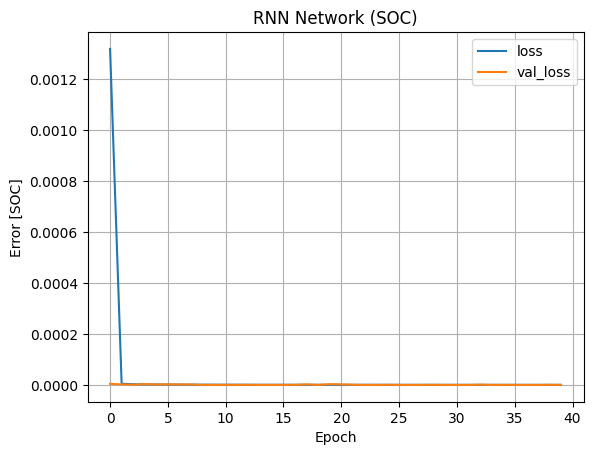

In [42]:
plot_loss(history[-1], 'RNN Network (SOC)')

In [43]:
model_path = os.path.join("models","RNN_SOC_02.keras")

In [44]:
rnn_model.save(model_path)

### Performance

In [48]:
rnn_model = tf.keras.models.load_model(model_path)

In [49]:
test_predictions = rnn_model.predict(X_test).flatten()

3675/3675 [==============================] - 6s 2ms/step


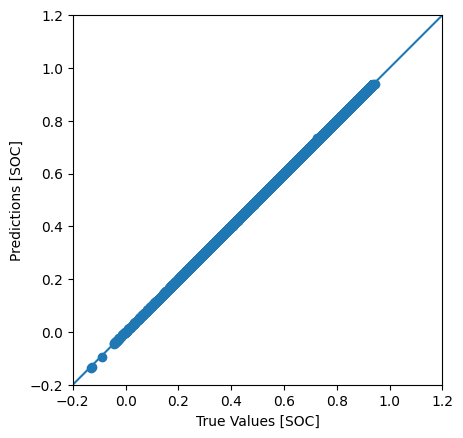

In [50]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [SOC]')
plt.ylabel('Predictions [SOC]')
lims = [-0.2, 1.2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

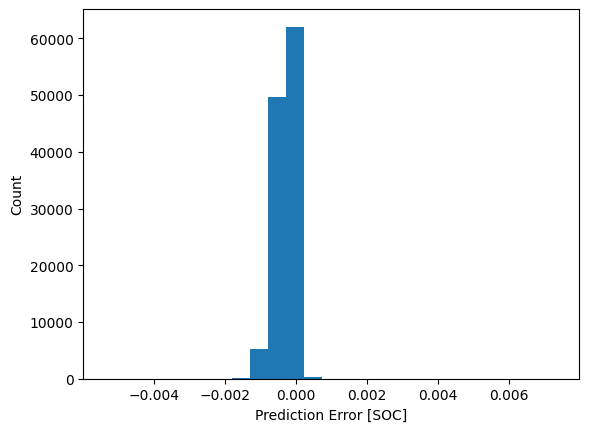

In [51]:
error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [SOC]')
_ = plt.ylabel('Count')

In [52]:
# Calculate metrics
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')

MSE: 1.5168865968207787e-07
RMSE: 0.0003894722835864933
MAE: 0.0003051182471474292
R2 Score: 0.9999913965874604
